In [1]:
import os
import numpy as np
from PIL import Image
from scipy.io import loadmat
from tensorflow.keras.applications import EfficientNetB3
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
from google.colab import drive

In [2]:
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
# Dataset Paths
datasets_train = [
    ("/content/drive/MyDrive/shanghaitech/ShanghaiTech/part_A/train_data/images",
     "/content/drive/MyDrive/shanghaitech/ShanghaiTech/part_A/train_data/ground-truth"),
    ("/content/drive/MyDrive/shanghaitech/ShanghaiTech/part_B/train_data/images",
     "/content/drive/MyDrive/shanghaitech/ShanghaiTech/part_B/train_data/ground-truth")
]

datasets_test = [
    ("/content/drive/MyDrive/shanghaitech/ShanghaiTech/part_A/test_data/images",
     "/content/drive/MyDrive/shanghaitech/ShanghaiTech/part_A/test_data/ground-truth"),
    ("/content/drive/MyDrive/shanghaitech/ShanghaiTech/part_B/test_data/images",
     "/content/drive/MyDrive/shanghaitech/ShanghaiTech/part_B/test_data/ground-truth")
]

In [7]:
# Parameters
IMAGE_SIZE = (300, 300)
NUM_CLASSES = 2  # Low, High crowd density classes

# Extract head count from ground truth
def get_head_count(gt_file_path):
    gt_data = loadmat(gt_file_path)
    head_count = len(gt_data["image_info"][0][0][0][0][0])
    return head_count

# Load EfficientNetB3 as feature extractor
base_model = EfficientNetB3(weights='imagenet', include_top=False, input_shape=(300, 300, 3))
global_avg_layer = GlobalAveragePooling2D()

# Preprocess images and extract features
def load_features_and_labels(dataset_paths):
    features = []
    labels = []
    for dataset_path, ground_truth_path in dataset_paths:
        image_files = sorted(os.listdir(dataset_path))
        for img_file in image_files:
            img_path = os.path.join(dataset_path, img_file)
            gt_file = os.path.join(ground_truth_path, f"GT_{os.path.splitext(img_file)[0]}.mat")

            if os.path.exists(gt_file):
                head_count = get_head_count(gt_file)

                img = Image.open(img_path).convert('RGB')
                img_resized = img.resize(IMAGE_SIZE)
                img_array = np.array(img_resized) / 255.0
                img_array = np.expand_dims(img_array, axis=0)

                feature = base_model.predict(img_array, verbose=0)
                pooled_feature = global_avg_layer(feature).numpy().flatten()

                features.append(pooled_feature)

                if head_count <= 160:
                    labels.append(0)  # Low Density
                else:
                    labels.append(1)  # High Density
    return np.array(features), np.array(labels)

In [8]:
# Load training and testing data
train_features, train_labels = load_features_and_labels(datasets_train)
test_features, test_labels = load_features_and_labels(datasets_test)

# Split into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(train_features, train_labels, test_size=0.2, random_state=42)

# Define and compile a simple dense classifier
input_shape = train_features.shape[1]
input_layer = Input(shape=(input_shape,))
dense_layer = Dense(128, activation='relu')(input_layer)
out_layer = Dense(1, activation='sigmoid')(dense_layer)
model = Model(inputs=input_layer, outputs=out_layer)

model.compile(optimizer=Adam(learning_rate=0.01), loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=20, batch_size=16, verbose=1)

Epoch 1/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - accuracy: 0.5180 - loss: 1.0439 - val_accuracy: 0.5000 - val_loss: 0.6935
Epoch 2/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.4699 - loss: 0.6950 - val_accuracy: 0.5000 - val_loss: 0.6931
Epoch 3/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.4879 - loss: 0.6931 - val_accuracy: 0.5000 - val_loss: 0.6935
Epoch 4/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.5261 - loss: 0.6919 - val_accuracy: 0.5000 - val_loss: 0.6942
Epoch 5/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5427 - loss: 0.6905 - val_accuracy: 0.5000 - val_loss: 0.6941
Epoch 6/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5028 - loss: 0.6940 - val_accuracy: 0.5000 - val_loss: 0.6942
Epoch 7/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5330 - loss: 0.6914 - val_accuracy: 0.5000 - val_loss: 0.6944
Epoch 8/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5457 - loss: 0.6905 - val_accuracy: 0.5000 - val_loss

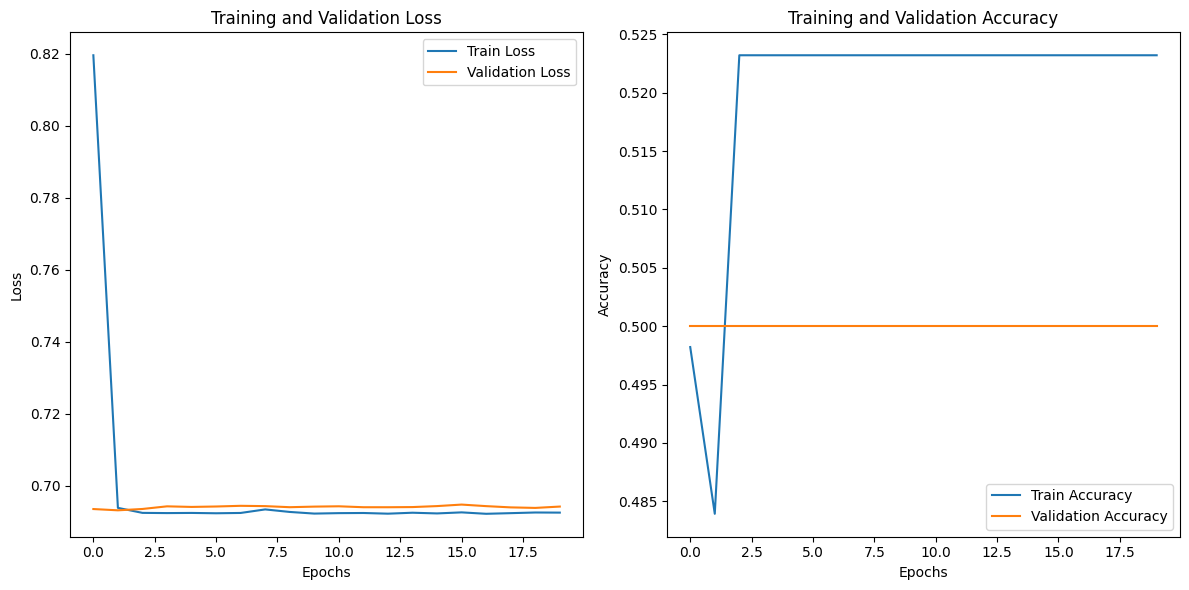

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Classification Report:
               precision    recall  f1-score   support

 Low Density       0.00      0.00      0.00       252
High Density       0.49      1.00      0.66       246

    accuracy                           0.49       498
   macro avg       0.25      0.50      0.33       498
weighted avg       0.24      0.49      0.33       498



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


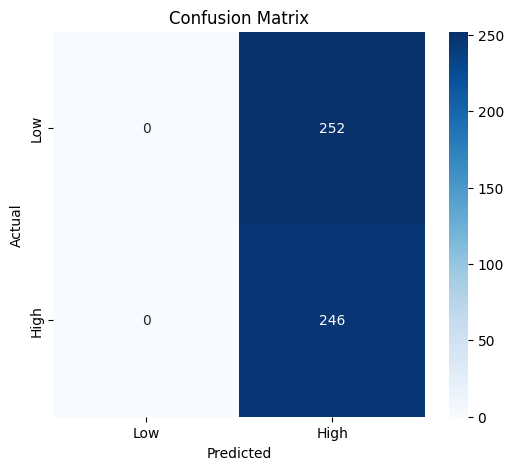

In [9]:
# Plot Accuracy and Loss
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

# Predictions
y_pred = (model.predict(test_features) > 0.5).astype("int32")

# Compute confusion matrix
conf_matrix = confusion_matrix(test_labels, y_pred)

# Compute classification metrics
report = classification_report(test_labels, y_pred, target_names=['Low Density', 'High Density'])
print("Classification Report:\n", report)

# Plot Confusion Matrix
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Low', 'High'], yticklabels=['Low', 'High'])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()